In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

2024-07-26 16:18:56.112691: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 16:18:56.130445: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 16:18:56.202872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 16:18:56.326335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 16:18:56.359354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 16:18:56.434381: I tensorflow/core/platform/cpu_feature_gu

# Génération Toy Dataset

In [7]:
def create_toy_dataset(n_points=N_POINTS, K=4, p_noise=0.15, pi_gaussiennes=None, sigma_max=None):
    """Create toy dataset of K random 2D gaussians, with noise

    Args:
        n_poins (_type_, optional): total number of points of the dataset. Defaults to N_POINTS.
        K (int, optional): number of gaussians. Defaults to 4.
        p_noise (float, optional): probability of sampling a noise point. Defaults to 0.15.
        p_gaussiennes (_type_, optional): list of probabilities of sampling from each gaussian. sums to 1-p_noise. Defaults to None.
        
    - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
    - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes
    """
    
    if pi_gaussiennes==None:
        pi_gaussiennes = [(1-p_noise)/K] * K
    
    points = np.zeros(shape=(n_points,2))
    labels = np.zeros(shape=(n_points))
    choices = np.arange(K)

    # create Gaussians
    mus = np.random.uniform(low=-1.0, high=1.0, size=(K,2))
    
    if sigma_max==None:
        sigma_max = SIGMA_MAX
    covs = np.zeros(shape=(K,2,2))

    for i in range(K):
        diag = np.array( [ [np.random.uniform(low=0.0, high=sigma_max),0], [0, np.random.uniform(low=0.0, high=sigma_max)] ] )
        theta = np.random.uniform(low=0, high=2*np.pi)
        ortho = np.array( [ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        covs[i] = np.matmul( np.transpose(ortho), np.matmul(diag, ortho) )
        
    rng = np.random.default_rng()

    for i in range(n_points):
        p = np.random.uniform()
        if p <= p_noise:
            point = np.random.uniform(low=-1.0-sigma_max*3, high=1+sigma_max*3, size=2)
            label = -1
        else:
            n_gaussienne = np.random.choice(choices)
            label = n_gaussienne
            mu = mus[n_gaussienne]
            sigma = covs[n_gaussienne]
            point = rng.multivariate_normal(mean=mu, cov=sigma)
        points[i] = point
        labels[i] = label
        
    return points, labels, mus, covs, sigma_max

In [8]:
def pdf(mu, cov, x):
    """calcule pdf du point x wrt gaussienne (mu, cov)"""
    determinant = np.linalg.det(cov)
    inverse_sigma = np.linalg.inv(cov)
    D = mu.shape[0]
    pdf = 1/(((2*np.pi)**(D/2))*determinant**(1/2))*np.exp(-1/2*np.matmul((x-mu), np.matmul(inverse_sigma, (x-mu))))
    pdf = pdf.flatten()[0]
    
    return pdf

In [9]:
def display_dataset(points, labels, mus, covs, sigma_max):
    """display dataset"""
    
    fig, ax  = plt.subplots(figsize=(6,6))

    # affiche tous les points
    ax.scatter(points[:,0], points[:,1], c=labels, marker='.', s=2.0, alpha=1.0)
    ax.set_xlim(left=-1.0-sigma_max*5, right=1+sigma_max*5)
    ax.set_ylim(bottom=-1.0-sigma_max*5, top=1+sigma_max*5)
    ax.grid(True)
    
    # affiche les centres des gaussiennes et des contours
    K = mus.shape[0]
    
    for i in range(K):
        # affiche centre
        x_mu = mus[i,0]
        y_mu = mus[i,1]
        ax.scatter(x_mu, y_mu, label=f'Gaussienne {K}', s=100.0, marker='x')
        # calcule contours
        delta = 1.0
        nx = 20
        x = np.linspace( x_mu - delta, x_mu + delta, num=nx)
        # print(x)
        ny = 20
        y = np.linspace( y_mu - delta, y_mu + delta, num=ny)
        # print(y)
        X, Y = np.meshgrid(x, y) # X a shape nx.ny, Y a shape nx.ny
        # print(X)
        # print(Y)
        Z = np.zeros(shape=(ny,nx))
        for j in range(ny):
            for k in range(nx):
                xc = X[j,k]
                yc = Y[j,k]
                point = np.array([xc,yc])
                # print(point)
                Z[j,k] = pdf(mus[i], covs[i], point)
        ax.contour(X,Y,Z)

    return fig, ax

In [183]:
# idée :
# - génération de bruit ~ Uniform([-1,-1],[1,1]) avec proba p_noise
# - génération de points samplés parmis K gaussiennes avec proba p_gaussiennes

p_noise = 0.0
K = 6  # nombre de Gaussiennes
pi_gaussiennes = [(1-p_noise)/K] * K
N_POINTS = 5000
SIGMA_MAX = 0.10

points, labels, mus, covs, sigma_max = create_toy_dataset(n_points=N_POINTS, K=K, p_noise=p_noise, pi_gaussiennes=pi_gaussiennes, sigma_max=SIGMA_MAX)

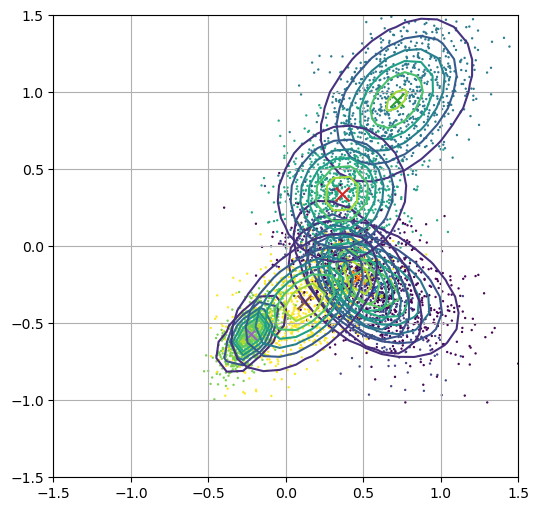

In [184]:
# points, labels, mus, covs, sigma_max = create_toy_dataset(n_points=N_POINTS, K=K, p_noise=p_noise, pi_gaussiennes=pi_gaussiennes)

fig, ax = display_dataset(points, labels, mus, covs, sigma_max)

In [185]:
points.shape

(5000, 2)

### Variational AutoEncoder - from F Chollet's keras3 doc

In [186]:
# Sampling layer

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent variable encoding an input."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(42)

    def call(self, inputs):
        z_mean, z_log_var = inputs  # log var plutôt que l'écart type
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        # reparametrisation trick from original article Kingma and Welling, “Auto-Encoding Variational Bayes”, ICLR 2014
        scale = 0.1 # tentative de diminuer le bruit pour éviter le posterior collapse... on sample "étroit" ?
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon * scale

In [187]:
input_dim = 2
output_dim = 2
latent_dim = 2

### Encoder

In [188]:
encoder_inputs = keras.Input(shape=(input_dim,))

# basic MLP
x = layers.Dense(64, activation="relu")(encoder_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation="relu")(x)

# output mean et log_var de la gaussienne
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# sample de la gaussienne inférée par le MLP
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 64)        │        192 │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_88 (Dense)    │ (None, 32)        │      2,080 │ dense_87[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_89 (Dense)    │ (None, 16)        │        528 │ dense_88[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_89[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_89[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_13         │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,868 (11.20 KB)

 Trainable params: 2,868 (11.20 KB)

 Non-trainable params: 0 (0.00 B)

### Decoder

In [189]:
# input : vecteur de l'espace latent
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(16, activation="relu")(latent_inputs)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)

decoder_outputs = layers.Dense(output_dim)(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,834 (11.07 KB)

 Trainable params: 2,834 (11.07 KB)

 Non-trainable params: 0 (0.00 B)

### VAE

In [190]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        # encodeur vers l'espace latent
        self.encoder = encoder
        # décodeur depuis l'espace latent
        self.decoder = decoder
        # losses
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # une étape de forward pass, avec différentiation des losses
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)  # forward pass de l'encodeur
            reconstruction = self.decoder(z)  # veceteur reconstruit depuis la variable latent samplée
            # 1ere loss : erreur reconstruction entre la data et la reconstruction
            reconstruction_loss = ops.mean(keras.losses.mean_squared_error(data, reconstruction)),  # norme L2 pour calculer l'erreur de reconstruction
            # 2e loss : KL entre le posterior z|x appris par l'encodeur et N(0,I) cible
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            # loss totale (ELBO)
            total_loss = reconstruction_loss + kl_loss
            
        # calcul des gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train VAE

In [191]:
x_train = points

x_train.shape

(5000, 2)

In [192]:
# basic training

vae = VAE(encoder, decoder)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    restore_best_weights=True,
    # mode='min'
)

vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=1000, batch_size=128, callbacks=[callback])

Epoch 1/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - kl_loss: 0.0062 - loss: 0.2475 - reconstruction_loss: 0.2412
Epoch 2/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - kl_loss: 0.0253 - loss: 0.1092 - reconstruction_loss: 0.0839
Epoch 3/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - kl_loss: 0.0329 - loss: 0.0844 - reconstruction_loss: 0.0515
Epoch 4/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - kl_loss: 0.0325 - loss: 0.0743 - reconstruction_loss: 0.0417
Epoch 5/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - kl_loss: 0.0324 - loss: 0.0764 - reconstruction_loss: 0.0440
Epoch 6/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - kl_loss: 0.0330 - loss: 0.0750 - reconstruction_loss: 0.0420
Epoch 7/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - kl_loss: 0.0327 - loss: 0.0747 - reconstruction_loss: 0.0419
Epoch 8/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - kl_loss: 0.0336 - loss: 0.0756 - reconstruction_loss: 0.0420
Epoch 9/1000
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - kl_loss: 0.0325 

### Display latent space

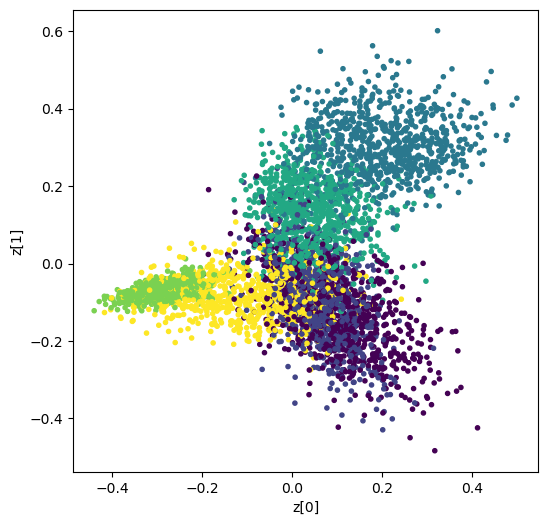

In [193]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(6, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], marker='.', c=labels)
    # plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, points, labels)

In [194]:
points[:10]

array([[ 0.47408492, -0.0697965 ],
       [ 0.49718438,  0.87533532],
       [ 0.53920487,  0.00195093],
       [ 0.54717719, -0.26044404],
       [-0.09443067, -0.48568883],
       [ 0.62262988, -0.46070184],
       [-0.13964289, -0.46614539],
       [ 0.17304492,  0.0533081 ],
       [ 0.41600272,  0.18684845],
       [-0.51485452, -0.70843005]])

In [195]:
z_mean, z_log_var, z = encoder(points[:10])

In [196]:
z_mean

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 0.07781566, -0.05163722],
       [ 0.09677538,  0.31292307],
       [ 0.10563549, -0.031069  ],
       [ 0.08779954, -0.1288794 ],
       [-0.232005  , -0.06898851],
       [ 0.10002162, -0.21217477],
       [-0.24158248, -0.0583414 ],
       [-0.02885056,  0.02909978],
       [ 0.06164961,  0.05539095],
       [-0.3883869 , -0.06766333]], dtype=float32)>

In [197]:
z_log_var

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-0.0296092 , -0.04053018],
       [-0.0408009 , -0.0423601 ],
       [-0.02477102, -0.04746777],
       [-0.03349906, -0.02894489],
       [-0.04167533, -0.01544716],
       [-0.03285282, -0.01632871],
       [-0.04407386, -0.01538672],
       [-0.04826505, -0.03000094],
       [-0.03412813, -0.04141964],
       [-0.05348055, -0.00307954]], dtype=float32)>

In [198]:
z

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 0.08224972, -0.1413427 ],
       [ 0.23059472,  0.22918843],
       [ 0.17116413,  0.12248421],
       [ 0.16127932, -0.0592757 ],
       [-0.2666783 , -0.1823624 ],
       [ 0.0875567 , -0.23685731],
       [-0.16635336, -0.16557634],
       [-0.1888642 ,  0.24068148],
       [ 0.09499238,  0.10867396],
       [-0.49426275, -0.02622003]], dtype=float32)>

In [199]:
decoded = decoder(z)
decoded

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 0.492488  , -0.23605293],
       [ 0.6883096 ,  0.79635113],
       [ 0.5572664 ,  0.44493327],
       [ 0.54289997, -0.09190211],
       [-0.16794987, -0.5720357 ],
       [ 0.5649219 , -0.3607743 ],
       [ 0.01647899, -0.46175024],
       [ 0.1271008 ,  0.3190636 ],
       [ 0.44017366,  0.31386444],
       [-0.30036417, -0.6678601 ]], dtype=float32)>

In [200]:
points[:10]

array([[ 0.47408492, -0.0697965 ],
       [ 0.49718438,  0.87533532],
       [ 0.53920487,  0.00195093],
       [ 0.54717719, -0.26044404],
       [-0.09443067, -0.48568883],
       [ 0.62262988, -0.46070184],
       [-0.13964289, -0.46614539],
       [ 0.17304492,  0.0533081 ],
       [ 0.41600272,  0.18684845],
       [-0.51485452, -0.70843005]])